In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## MSA Phase 2 Part 3: Image Classification

Goal: Predict the correct class of a given image.

We are given 50,000 training images and 10,000 test images. Each image is 32 x 32 and consist of 10 classes:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck


## Import libraries

In [2]:
#import libraries
import torch
import torchvision
from torchvision import datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


import os
import pandas as pd
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader,random_split
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2

import numpy as np
import copy

import fnmatch
import csv

from sklearn.metrics import accuracy_score,  f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, roc_curve

## Load Training Dataset and image preprocessing
Load the images in the training dataset and create a train-validation-test split for model training and evaluation. I have chosen a 70-20-10 split.

Image preprocessing includes applying random horizontal flipping, resizing to 32x32 (in case some are different sizes), scaling pixels to [0,1] range and normalizing.

In [3]:
#Define a custom dataset loader for image loading
class CustomImageDataset(Dataset):
    def __init__(self, labels_file, imgs_dir, transform=None):
        self.img_labels = pd.read_csv(labels_file)
        self.imgs_dir = imgs_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, 'image_'+str(self.img_labels.iloc[idx, 0])+'.png')
        image = read_image(img_path, ImageReadMode.RGB)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
#path to train images and annotations file with labels
path_to_train_folder = '/kaggle/input/nzmsa-2024/cifar10_images/train'
labels_file = '/kaggle/input/nzmsa-2024/train.csv'

## Image Preprocessing
#Define a transformation to apply to images
transform = v2.Compose([
    v2.RandomRotation(degrees=(0,90)),
    v2.RandomHorizontalFlip(p=0.5),# some random transforms to diversify the data
    v2.Resize((32,32), antialias=True),#Resize images
    v2.ToDtype(torch.float32, scale=True),  # Convert type to float and scale to [0,1]
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),# Convert data to a normalized torch.FloatTensor
])


#load training dataset
train_dataset = CustomImageDataset(labels_file=labels_file,
                                   imgs_dir=path_to_train_folder,
                                   transform = transform)

#load and split train images into train-valid-test split
batch_size=120
valid_size=0.2
test_size=0.1
train_length = len(train_dataset)
split_val_size = int(np.floor(valid_size * train_length))
split_test_size = int(np.floor(test_size * train_length))
split_train_size = train_length-split_test_size-split_val_size


train_split, valid_split, test_split = random_split(train_dataset,[split_train_size,split_val_size, split_test_size])
print(f'len train: { len(train_split)} len valid: { len(valid_split)} len test: { len(test_split)}')

train_dataloader = DataLoader(train_split,batch_size=batch_size,shuffle=True)
valid_dataloader = DataLoader(valid_split,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_split,batch_size=batch_size,shuffle=False)

len train: 35000 len valid: 10000 len test: 5000


## Visualise training data


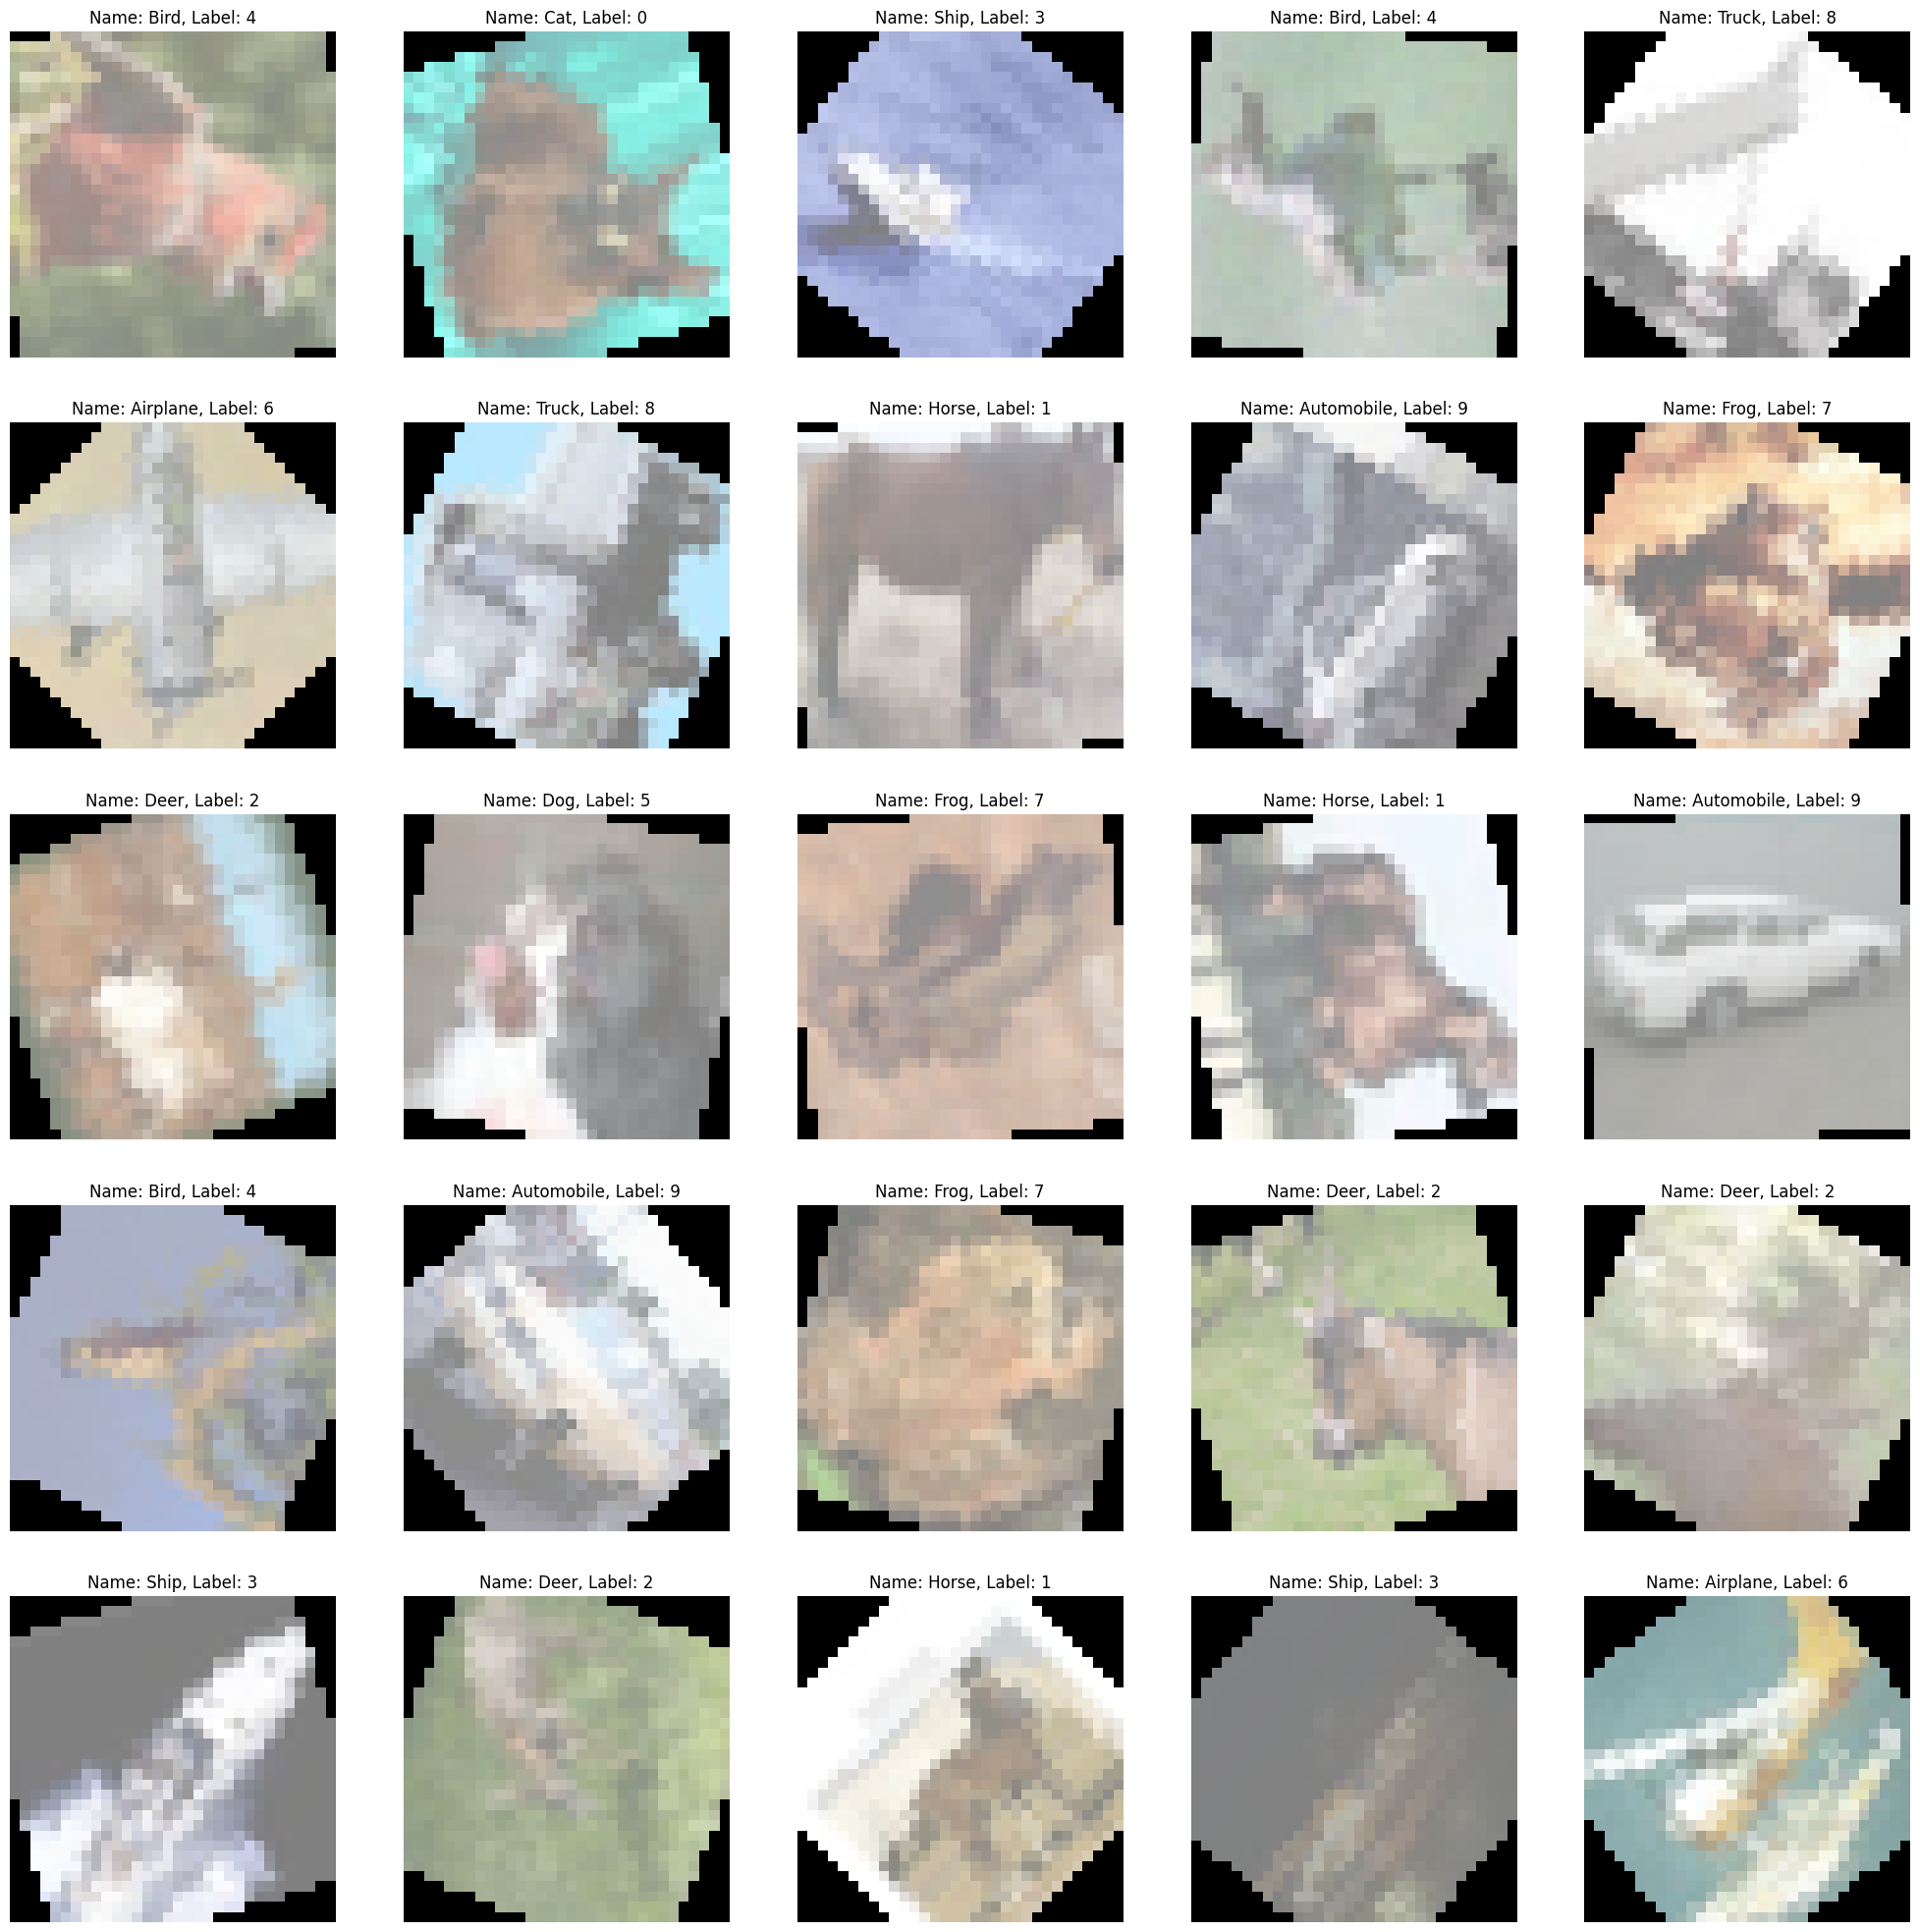

In [5]:
#Label names determined by looking at train images
label_names = { 0: 'Cat',
1: 'Horse',
2: 'Deer',
3: 'Ship',
4: 'Bird',
5: 'Dog',
6: 'Airplane',
7: 'Frog',
8: 'Truck',
9: 'Automobile'}

def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  plt.imshow(img.permute(1,2,0))

# Plot the images in the batch
fig = plt.figure(figsize=(25, 25))

num_images_vis = np.min([batch_size, 25])
# Display some train images
# train_images, train_labels = next(iter(train_dataloader))
for idx in np.arange(num_images_vis):
    train_images, train_labels = train_dataloader.dataset[idx]
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    imshow(train_images)
    ax.set_title('Name: '+str(label_names[train_labels.item()]) +', Label: '+ str(train_labels.item()))
    ax.axis('off')

# Model construction

A CNN model was decided for training.

In [6]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### CNN Architecture

Our aritecture consists of:

- An input layer
- Two convolutional layers with a ReLU activation function.
- Following each convolutional layer we normalise across the batch and apply is a max pooling layer.
- A Flattening layer.
- A dropout layer.
- Two dense layers with a ReLU activation function.
- Another dropout layer.
- An output layer with softmax activation.

In [7]:
# Architecture of our convolution neural network

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
# Instantiate a neural network model 
net = Net().to(device)


### Define a loss function

We use cross entropy for our loss function and Adam as an optimizer.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Network training

In our training loop for each epoch we have a train loop and a validation loop. In the validation loop we evaluate the trained model for the current epoch measuring it's performance for metrics defined in calc_metrics. 

We also track the validation loss against the training loss and implement an early stopping when the val_loss is no longer decreasing, saving the best weights.

In [9]:
# define a function for calculating metrics
def calc_metrics(predictions, labels):
    #convert to numpy arrays
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    
    #calculate metrics
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted', zero_division=1)
    recall = recall_score(labels, predictions, average='weighted', zero_division=1)
    
    return acc, f1, precision, recall

In [10]:
# Initialize metric lists
train_losses = []
val_losses=[]
train_accs = []
val_accs=[]
train_f1s = []
val_f1s=[]
train_precisions = []
val_precisions=[]
train_recalls = []
val_recalls=[]

#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 10

num_epochs = 40
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    train_loss = 0.0
    val_loss=0.0  
    
    train_acc = 0.0
    train_f1 = 0.0
    train_precision = 0.0
    train_recall = 0.0
    
    val_acc = 0.0
    val_f1 = 0.0
    val_precision = 0.0
    val_recall = 0.0
    
    ## Training step
    net.train()
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # accumulate loss
        train_loss += loss.item()
        
        _,preds=torch.max(outputs,1)
        
        # Calculate metrics
        acc, f1, precision, recall = calc_metrics(preds, labels)
        train_acc += acc
        train_f1 += f1
        train_precision += precision
        train_recall += recall
        
    ## Validation step
    net.eval()
    for i, data in enumerate(valid_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        val_inputs, val_labels = data
        val_inputs=val_inputs.to(device)
        val_labels=val_labels.to(device)
        
        # get output of model
        val_outputs = net(val_inputs)
        
        # loss
        loss = criterion(val_outputs, val_labels)
        
        # accumulate loss
        val_loss+=loss.item()
        
        _,val_preds=torch.max(val_outputs,1)
        
        # Calculate metrics
        acc, f1, precision, recall = calc_metrics(val_preds, val_labels)
        val_acc += acc
        val_f1 += f1
        val_precision += precision
        val_recall += recall
        
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(net.state_dict())  # Deep copy here      
        patience = 10  # Reset patience counter
        print(f'Model weights saved at epoch {epoch}')
    else:
        patience -= 1
        if patience == 0:
            break
    
    ## Average metrics
    #average losses
    av_train_loss = train_loss/len(train_dataloader)
    av_val_loss = val_loss/len(valid_dataloader)
    train_losses.append(av_train_loss)
    val_losses.append(av_val_loss)
    
    #average metrics
    #accuracy
    av_train_acc = train_acc/len(train_dataloader)
    av_val_acc = val_acc/len(valid_dataloader)
    train_accs.append(av_train_acc)
    val_accs.append(av_val_acc)
    #f1
    av_train_f1 = train_f1/len(train_dataloader)
    av_val_f1 = val_f1/len(valid_dataloader)
    train_f1s.append(av_train_f1)
    val_f1s.append(av_val_f1)
    #precision
    av_train_precision = train_precision/len(train_dataloader)
    av_val_precision = val_precision/len(valid_dataloader)
    train_precisions.append(av_train_precision)
    val_precisions.append(av_val_precision)
    #recall
    av_train_recall = train_recall/len(train_dataloader)
    av_val_recall = val_recall/len(valid_dataloader)
    train_recalls.append(av_train_recall)
    val_recalls.append(av_val_recall)
    
    
    
    # print-training/validation-statistics 
    print('Epoch: {}/{},\tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        (epoch+1), num_epochs, av_train_loss, av_val_loss, av_train_acc, av_val_acc))
# Load the best model weights
net.load_state_dict(best_model_weights)
print('Finished Training')

Model weights saved at epoch 0
Epoch: 1/40,	Training Loss: 2.238364 	Validation Loss: 2.177196 	Training Accuracy: 0.196718 	Validation Accuracy: 0.273214
Model weights saved at epoch 1
Epoch: 2/40,	Training Loss: 2.168574 	Validation Loss: 2.131723 	Training Accuracy: 0.282192 	Validation Accuracy: 0.319544
Model weights saved at epoch 2
Epoch: 3/40,	Training Loss: 2.140025 	Validation Loss: 2.117136 	Training Accuracy: 0.312800 	Validation Accuracy: 0.338591
Epoch: 4/40,	Training Loss: 2.126205 	Validation Loss: 2.131464 	Training Accuracy: 0.327426 	Validation Accuracy: 0.320933
Model weights saved at epoch 4
Epoch: 5/40,	Training Loss: 2.119065 	Validation Loss: 2.093947 	Training Accuracy: 0.334304 	Validation Accuracy: 0.358532
Epoch: 6/40,	Training Loss: 2.108096 	Validation Loss: 2.096478 	Training Accuracy: 0.344991 	Validation Accuracy: 0.355556
Model weights saved at epoch 6
Epoch: 7/40,	Training Loss: 2.105519 	Validation Loss: 2.083567 	Training Accuracy: 0.348516 	Validat

### Save model

In [11]:
import joblib
joblib.dump(net, 'net.joblib')
# net = joblib.load('/kaggle/input/net/pytorch/default/1/net.joblib') #option to load model if needed

['net.joblib']

### Plot Losses and metrics
Here we visualise the metrics.

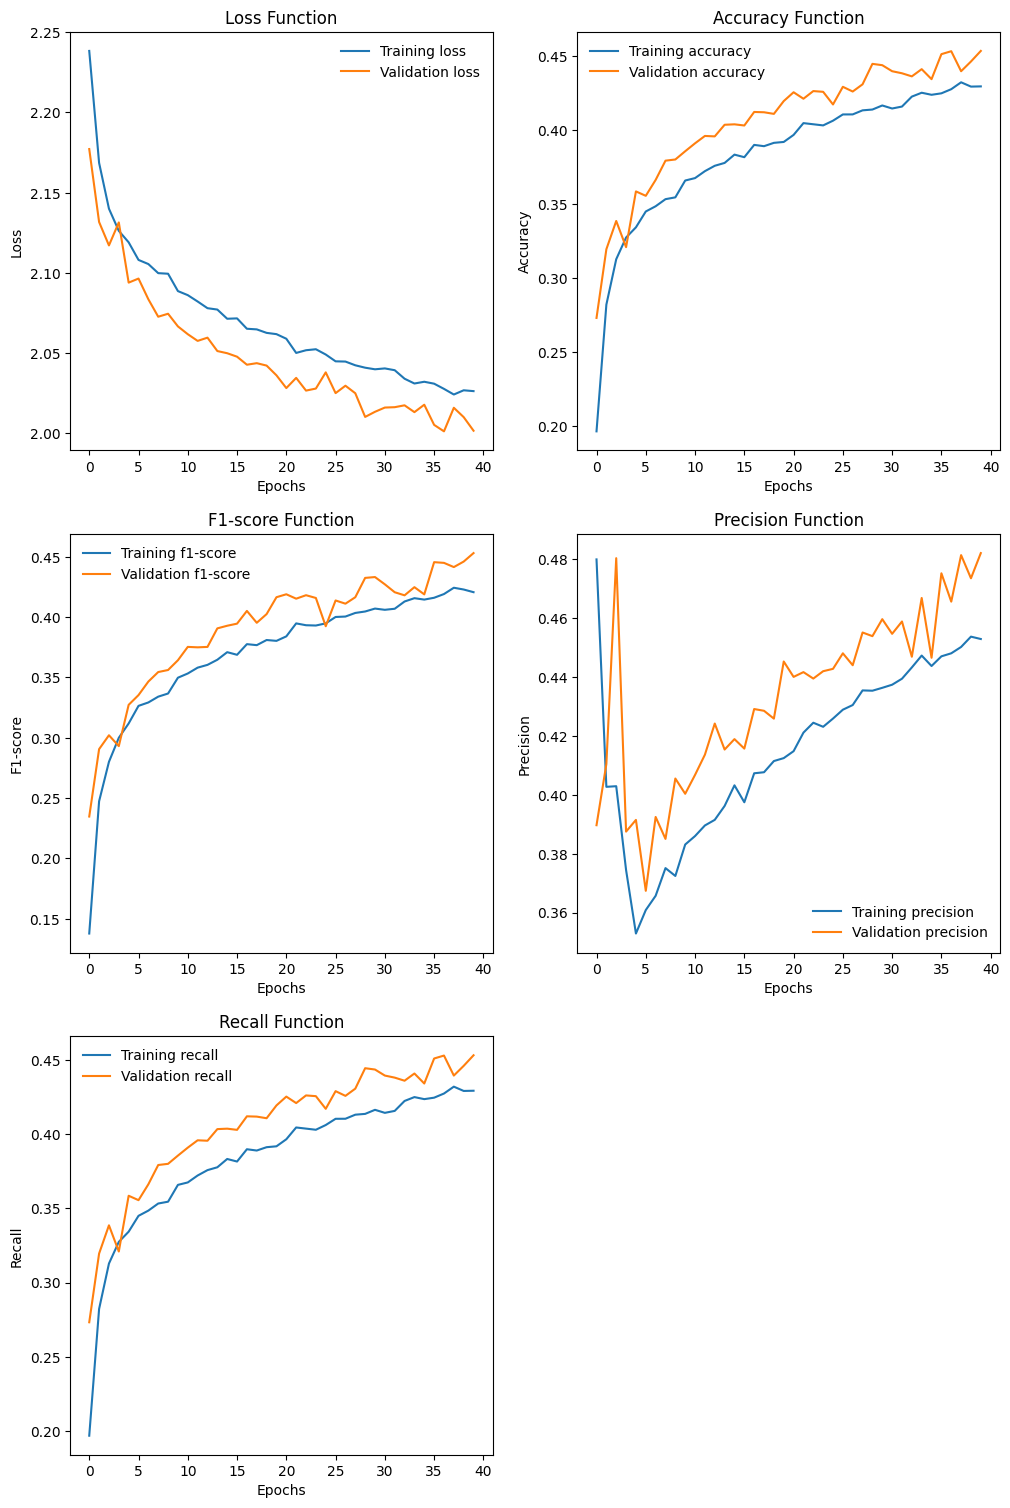

In [12]:
plt.figure(figsize=(12, 25))
plt.subplot(4, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Function")
plt.legend(frameon=False)

# plot accuraccy
plt.subplot(4, 2, 2)
plt.plot(train_accs, label = 'Training accuracy')
plt.plot(val_accs, label = 'Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Function")
plt.legend(frameon=False)

#plot f1
plt.subplot(4, 2, 3)
plt.plot(train_f1s, label = 'Training f1-score')
plt.plot(val_f1s, label = 'Validation f1-score')
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.title("F1-score Function")
plt.legend(frameon=False)

# plot precision
plt.subplot(4, 2, 4)
plt.plot(train_precisions, label = 'Training precision')
plt.plot(val_precisions, label = 'Validation precision')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision Function")
plt.legend(frameon=False)

# plot recall
plt.subplot(4, 2, 5)
plt.plot(train_recalls, label = 'Training recall')
plt.plot(val_recalls, label = 'Validation recall')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall Function")
plt.legend(frameon=False)

## Performance analysis
### Test the model on our test split images

We evaluate the images on our test split images to see the models performance after fully trained


In [13]:
# 
# Evaluate the model using PyTorch
net.eval()
lab_true = []
lab_pred = []

for i, data in enumerate(test_dataloader, 0):
    test_images, test_labels = data
    test_images=test_images.to(device)
    test_labels=test_labels.to(device)
    outputs = net(test_images)
    _, test_preds = torch.max(outputs, 1)
    lab_pred.extend(test_preds.cpu().numpy()) # predicted labels
    lab_true.extend(test_labels.cpu().numpy()) # true labels   

    
# Convert lists to tensors for calculation
lab_true_tensor = torch.tensor(lab_true)
lab_pred_tensor = torch.tensor(lab_pred)    

# Calculate metrics
test_acc, test_f1, test_precision, test_recall = calc_metrics(lab_pred_tensor, lab_true_tensor)


print(f'Precision: {test_precision}')
print(f'Recall: {test_recall}')
print(f'F1 Score: {test_f1}')
print(f'Accuracy of the network on the test images: {test_acc*100} %')


Precision: 0.435704947069002
Recall: 0.444
F1 Score: 0.4349283730370114
Accuracy of the network on the test images: 44.4 %


### Confusion Matrix

              precision    recall  f1-score   support

           0       0.31      0.28      0.30       543
           1       0.48      0.52      0.50       477
           2       0.37      0.45      0.41       516
           3       0.46      0.59      0.51       515
           4       0.28      0.18      0.22       477
           5       0.41      0.25      0.31       481
           6       0.48      0.50      0.49       485
           7       0.56      0.61      0.58       518
           8       0.47      0.55      0.51       503
           9       0.53      0.48      0.51       485

    accuracy                           0.44      5000
   macro avg       0.44      0.44      0.43      5000
weighted avg       0.44      0.44      0.43      5000



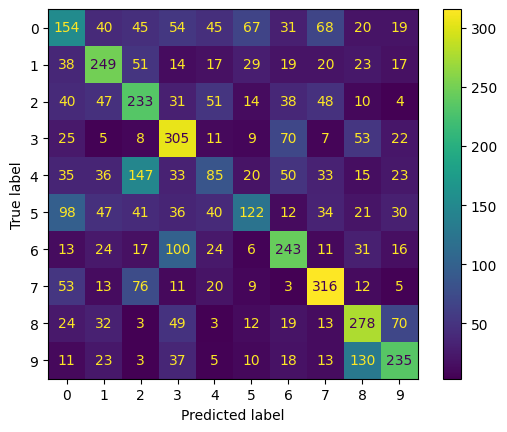

In [14]:
confusion_mx = confusion_matrix(lab_true, lab_pred)

ConfusionMatrixDisplay(confusion_mx).plot()


print(classification_report(lab_true, lab_pred))

## Predict Test labels
Now we predict labels for the given images in the test dataset for submission

In [15]:
#path to test dataset
path_test_dir = '/kaggle/input/nzmsa-2024/cifar10_images/test'
num_test_images = len(fnmatch.filter(os.listdir(path_test_dir), '*.png'))

#path to test dataset
path_to_test_folder = '/kaggle/input/nzmsa-2024/cifar10_images/test'

#Define a transformation to apply to images
test_transform = v2.Compose([
    v2.Resize((32,32), antialias=True),#Resize images
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),# Convert data to a normalized torch.FloatTensor
])

@torch.no_grad()
def classify(image_path,image_transform, classes):
    image =  read_image(image_path, ImageReadMode.RGB)
    image_tensor = image_transform(image)
#     plt.imshow(  image_tensor.permute(1, 2, 0)  )
    image_tensor.unsqueeze_(0)
    image_tensor=image_tensor.to(device)
    output = net(image_tensor)
    index = output.cpu().data.numpy().argmax()
    pred = classes[index]
    return pred, index

preds = []


# Predict labels
for i in range(num_test_images):
    path_test_dir = '/kaggle/input/nzmsa-2024/cifar10_images/test'
    path_test_image=os.path.join(path_test_dir, 'image_'+str(i)+'.png')
    prediction_name, prediction_label = classify(path_test_image, test_transform,label_names)
    preds.append([i, prediction_label])
    if i%500==0:
        print(f'Model predicts image {i} is label {prediction_label}, a {prediction_name}')
        




Model predicts image 0 is label 5, a Dog
Model predicts image 500 is label 0, a Cat
Model predicts image 1000 is label 1, a Horse
Model predicts image 1500 is label 5, a Dog
Model predicts image 2000 is label 4, a Bird
Model predicts image 2500 is label 0, a Cat
Model predicts image 3000 is label 1, a Horse
Model predicts image 3500 is label 2, a Deer
Model predicts image 4000 is label 8, a Truck
Model predicts image 4500 is label 6, a Airplane


## Write predictions to submission csv

In [16]:
# opening csv file
file = open('submission.csv', 'w+', newline ='')

with file:
    write = csv.writer(file)
    write.writerows([["id", "label"]])
    write.writerows(preds)

# Summary

For this image classification task a convolutional neural network was implemented. The image set was split into a test-validation-test split at a 70-20-10 ratio. Each image was normalised to a [0,1] range and had a random horizontal flip transformation applied. For training we implemented a training loop and a validation loop saving a number of metrics to evaluate our model at each epoch, including accuracy, precision, recall, f1-score and loss. An early stopping was also implemented to stop our training if the validation loss no longer improved, the model with best validation loss was saved.

Following our training metrics for the training and validation loops over each epoch were plotted and showed that training losses decreased and accurracy increased with epoch numbers. However, although the validation curve had the same general shape as the loss there is a lot of fluctuation, and the model is not generalising well, an indication of overfitting. 

With the saved model the test split was used to further evaluate the trained model the evaluation metrics show our model predicted ~55% (at the time of running) of the test split images overall. 

Plotting a confusion matrix gave insight into which images the model had trouble with differentiating between label 0 and 5 as well as 8 and 9.

Finally, the model was to predict the images given to us in the test folder, those without labels and the result was written to a csv file for submission.

Overall the model demonstrated an average performance. To try address the possibility of overfitting we did apply a number of dropout layers, but additional optimisation/regularisation techniques will help to improve performance of the model further.

